<a href="https://colab.research.google.com/github/julialromero/Collaborative-Problem-Solving/blob/main/learning_pipeline_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import os
from skimage import io
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras import layers, Input, Model, optimizers
from keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

PROJECT_DIR = "drive/MyDrive/CSCI 5922 - Final Project/"  #<--- Make a shortcut for the "CSCI 5922 - Final Project" shared folder on your Google Drive

Tue May  3 19:55:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get User Input

In [26]:
# Choose what size images to use
PROJECT_DIR = "drive/MyDrive/CSCI 5922 - Final Project/"  #<--- Make a shortcut for the "CSCI 5922 - Final Project" shared folder on your Google Drive
## "small" = 98x98, "med" = 332x332, "large" = 719x719
image_size = "small"
shuffled = False
chance = False
normalize = True
num_iters = 1
num_folds = 10
threshold = 0.5
num_epochs = 70

if image_size == "large":
  imgsize = (int(719/2), int(719/2)) 
  if shuffled:
    IMG_DIR = "719x719 - Recurrence_Matrices/RAW_SHUFFLED/"
  else:
    IMG_DIR = "719x719 - Recurrence_Matrices/RAW/"

elif image_size == "med":
  imgsize = (332, 332)
  if shuffled:
    IMG_DIR = "332x332 - Recurrence_Matrices/RAW_SHUFFLED/"
  else:
    IMG_DIR = "332x332 - Recurrence_Matrices/RAW/"

elif image_size == "small":
  imgsize = (98, 98)
  if shuffled:
    IMG_DIR = "98x98 - Recurrence_Matrices/RAW_SHUFFLED/"
  else:
    IMG_DIR = "98x98 - Recurrence_Matrices/RAW/"

print("Processing images from: ", IMG_DIR)

Processing images from:  98x98 - Recurrence_Matrices/RAW/


# Helper Functions

In [27]:
# read, preprocess, and scale images to uniform dimension

def extract_image(image_path):
    imag = io.imread(image_path, as_gray=True)
    x = image.img_to_array(imag)

    x = tf.image.resize(x, imgsize) 

    return x

'''
    Converts grayscale image to 3 channels in order to fit Inception v3 model
'''
def extract_image_inceptionv3(image_path):
    imag = io.imread(image_path, as_gray=True)
    x = image.img_to_array(imag)

    x = tf.image.resize(x, imgsize) 
    x = np.squeeze(np.stack((x,)*3))
    x = x.swapaxes(0,1)
    x = x.swapaxes(1,2)

    return x

def extract_score(filename, outcome_df, score_col="task_score"):
    #  match this file's id/block with task score and return
    groupid, splitname = filename.split("-")
    block = splitname.split("_")[0]
    row = outcome_df.loc[(outcome_df.GROUPID == int(groupid)) & (outcome_df.block == block)]
    if(row.shape[0] != 1):
        print(f"Error -- Number of task scores recorded is not 1 for block {block} and groupid {groupid}.")
        return np.nan
    score = row[score_col].values[0]
    return score


def extract_binary_score(filename, outcome_df, score_col="task_score", median_score=2):
    #  match this file's id/block with task score and return
    groupid, splitname = filename.split("-")
    block = splitname.split("_")[0]
    row = outcome_df.loc[(outcome_df.GROUPID == int(groupid)) & (outcome_df.block == block)]
    if(row.shape[0] != 1):
        print(f"Error -- Number of task scores recorded is not 1 for block {block} and groupid {groupid}.")
        return np.nan
    raw_score = row[score_col].values[0]
    if raw_score <= median_score:
        score = 0
    else:
        score = 1
    return score

def min_max_scaling(series):
    # https://datagy.io/pandas-normalize-column/
    return (series - series.min()) / (series.max() - series.min())

def get_fold_data(GROUPID_list, score_col, incv3=False, verbose=False):
  # read data to np arrays
  recurrence_plot_list = []
  if incv3:
    recurrence_plot_list_incv3 = []
  
  labels = []
  binary_labels = []

  for filename in os.listdir(PROJECT_DIR + IMG_DIR):
      # Check if file belongs to one of the teams in the desired group
      for GROUPID in GROUPID_list:
        if str(GROUPID) == filename.split("-")[0]:
          # preprocess image
          if incv3:
            t_incv3 = extract_image_inceptionv3(PROJECT_DIR + IMG_DIR + filename)
          else:
            t = extract_image(PROJECT_DIR + IMG_DIR + filename)

          # get task score
          lab = extract_score(filename, outcome_df, score_col)
          bin_lab = extract_binary_score(filename, outcome_df, score_col="task_score", median_score=2)

          # append data 
          if incv3:
            recurrence_plot_list_incv3.append(t_incv3)
          else:
            recurrence_plot_list.append(t)
          
          labels.append(lab)
          binary_labels.append(bin_lab)

  # convert to arrays 
  if incv3:
    recurrence_plot_list_incv3 = np.array(recurrence_plot_list_incv3)
    plot_list = recurrence_plot_list_incv3
  else:
    recurrence_plot_list = np.array(recurrence_plot_list)
    plot_list = recurrence_plot_list
  
  labels = np.array(labels)
  binary_labels = np.array(binary_labels)

  if verbose:
    print("\nFOLD DATA INFO: ")
    if incv3:
      print(f"\trecurrence_plot_list_incv3: {recurrence_plot_list_incv3.shape}")
    else:
      print(f"\trecurrence_plot_list: {recurrence_plot_list.shape}")
    
    binary_counts = dict(Counter(binary_labels))
    print("\tBinary label counts: ", binary_counts)

  return [plot_list, labels, binary_labels]
  


# Load Team Outcomes

In [28]:
outcome_df = pd.read_csv(PROJECT_DIR + "team_block_outcomes.csv")

# get median task_score
task_scores = outcome_df["task_score"]
median_task_score = np.median(task_scores)
mean_task_score = np.mean(task_scores)
print("median: ", median_task_score)
print("mean: ", mean_task_score)

# normalize task_score
outcome_df["norm_task_score"] = min_max_scaling(outcome_df["task_score"])

# score_counts = dict(Counter(task_scores))
# for key in score_counts:
#     print("%d: %d" % (key, score_counts[key]))

outcome_df

median:  2.0
mean:  3.5437956204379564


,GROUPID,block,CPS_and_ITN_mean,Valence,num_gold,num_silver,task_score,norm_task_score
0,1010,ExpBlock1,-0.304697,3.666667,1.0,1.0,3.0,0.200000
1,1010,ExpBlock2,-0.304697,3.666667,2.0,1.0,5.0,0.333333
2,1020,ExpBlock1,-0.389995,4.333333,0.0,2.0,2.0,0.133333
3,1020,ExpBlock2,-0.026413,4.666667,4.0,1.0,9.0,0.600000
4,1020,Warmup,-0.742380,3.666667,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...
269,10103,ExpBlock2,-0.026413,3.666667,1.0,1.0,3.0,0.200000
270,10103,Warmup,-1.405215,3.333333,1.0,2.0,4.0,0.266667
271,10104,ExpBlock1,-0.531224,3.000000,0.0,0.0,0.0,0.000000
272,10104,ExpBlock2,-1.023464,4.000000,0.0,1.0,1.0,0.066667


# Regression w/ Team-level Cross Validation

## Prep folds for team-level cross validation

In [29]:
# Define fold names
train_folds = []
test_folds = []
set_type = "test"
for j in range(1,num_folds+1): 
    col_name = "Fold" + str(j) + "_" + set_type
    test_folds.append(col_name)
    set_type = "train"  
    col_name = "Fold" + str(j) + "_" + set_type
    train_folds.append(col_name)
    set_type = "test"

folds_dict_list = []

# Split teams into 5 groups
teams = pd.unique(outcome_df.GROUPID)

# For every iteration
for i in range(1,num_iters+1):
    print("Iteration: ", i)
    teams = shuffle(teams, random_state=i)
    groups = np.array_split(teams, num_folds)
    
    # Define groups for each fold
    fold_groups = {}
    for j, (train_fold, test_fold) in enumerate(zip(train_folds, test_folds)):
        # make the current group the test group
        fold_groups[test_fold] = groups[j]
        # make all other groups the train group
        train_group = groups[:j] + groups[j+1:]
        train_group = [team for group in train_group for team in group]
        fold_groups[train_fold] = train_group
        
    ## Confirm that for each fold, there is no team overlap bewteen train and test set
    for j in range(1,num_folds+1):
        assert set(fold_groups['Fold'+str(j)+'_test']).isdisjoint(set(fold_groups['Fold'+str(j)+'_train'])), "There is overlap in train and test set " + str(j)
    
    print("* No team overlap *")

      
    # Add fold groups to dictionary
    folds_dict_list.append(fold_groups)
    

# Informational
print("\nNumber of iterations: ", len(folds_dict_list))

print("\nIterating through folds_dict_list to check for overlap...")
for i,dicti in enumerate(folds_dict_list):
    for j in range(1,num_folds+1):
        assert set(dicti['Fold'+str(j)+'_test']).isdisjoint(set(dicti['Fold'+str(j)+'_train'])), "There is overlap in train and test set " + str(j)
    
print("* No team overlap *")  



Iteration:  1
* No team overlap *

Number of iterations:  1

Iterating through folds_dict_list to check for overlap...
* No team overlap *


## Prepare Garcia model

In [35]:
# Resource: https://www.kaggle.com/code/guidosalimbeni/regression-with-convolutional-neural-network-keras/notebook

def get_reg_garcia_model():
  # Garcia-Ceja paper feeds CNN images with dims 100 x 100 x 4 (width x height x channels)
  # Labels are one hot encoded
  inputs = Input(shape=(imgsize[0], imgsize[1], 1))
  x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(inputs)
  x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.25)(x)
  x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
  x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.25)(x)
  x = layers.Dense(512, activation="relu")(x) 
  x = layers.Dropout(0.50)(x)
  x = layers.Flatten()(x)
  out = layers.Dense(1, activation="sigmoid")(x)   # TODO: Is this the proper output for regression? "linear" or "sigmoid"

  lr = 0.00001 # paper used 0.001
  eps = 1e-08  # paper used 1e-08, but keras default is 1e-07
  adam = keras.optimizers.Adam(learning_rate=lr, epsilon=eps)

  mse = tf.keras.metrics.MeanSquaredError()
  rmse = tf.keras.metrics.RootMeanSquaredError()
  mae = tf.keras.metrics.MeanAbsoluteError()
  cos_sim = tf.keras.metrics.CosineSimilarity(axis=1)
  
  model_reg = Model(inputs=inputs, outputs=out)
  model_reg.compile(
    optimizer=adam,
    loss="mse", 
    metrics=['accuracy', mse, rmse, mae, cos_sim]
  )

  return model_reg

model_reg = get_reg_garcia_model()
model_reg.summary()


Model: "model_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_54 (InputLayer)       [(None, 98, 98, 1)]       0         
                                                                 
 conv2d_212 (Conv2D)         (None, 96, 96, 16)        160       
                                                                 
 conv2d_213 (Conv2D)         (None, 94, 94, 16)        2320      
                                                                 
 max_pooling2d_106 (MaxPooli  (None, 47, 47, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_159 (Dropout)       (None, 47, 47, 16)        0         
                                                                 
 conv2d_214 (Conv2D)         (None, 45, 45, 32)        4640      
                                                          

## Garcia - Run team-level cross validation

Iteration:  1
	Fold:  1
[0.26666667 0.33333333 0.         0.06666667 0.4        0.13333333
 0.46666667 0.13333333 0.2        0.4        0.         0.
 0.73333333 0.2        0.         0.4        0.4        0.33333333
 0.8        0.2        0.13333333 0.6        0.2        0.06666667
 0.2        0.73333333 0.        ]
[0.2        0.33333333 0.         0.2        0.53333333 0.73333333
 0.2        0.         0.2        0.26666667 0.         0.06666667
 0.         0.13333333 0.6        0.         0.26666667 1.
 0.2        0.6        0.         0.13333333 0.13333333 0.13333333
 0.2        0.53333333 0.06666667 0.13333333 0.13333333 0.26666667
 0.13333333 0.         0.46666667 0.13333333 0.2        0.
 0.13333333 0.4        0.06666667 0.         0.         0.33333333
 0.06666667 0.         0.33333333 0.06666667 0.4        0.
 0.13333333 0.13333333 0.33333333 0.         0.26666667 0.66666667
 0.13333333 0.06666667 0.73333333 0.06666667 0.66666667 0.06666667
 0.06666667 0.13333333 0.         0

,iteration,mae,mse,rmse,r2,corrs,ps
0,1,0.235916,0.108192,0.328925,-1.059411,0.019379,0.750805


Averages over all iterations:
  MAE: 0.24
  MSE: 0.11
 RMSE: 0.33
   r2: -1.06
 Corr: 0.02
p-val: 0.7508049

Med corr: 0.02

Median iteration number:  1


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


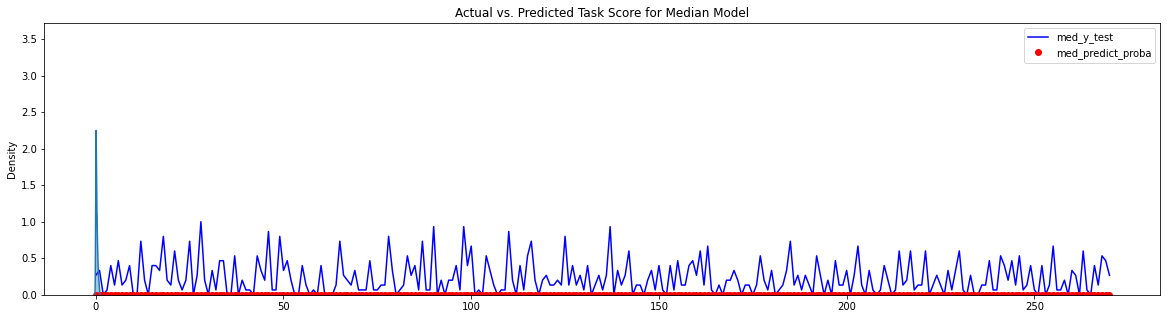

In [36]:
# Store metrics for all iterations
maes = []    # MAE (mean absolute errors)
mses = []    # MSE (mean squared errors)
rmses = []   # RMSE (root mean squared errors)
r2s = []     # r2 score
corrs = []   # spearman correlations
ps = []      # spearman correlation p-values

all_y_test_task_score = [[] for i in range(num_iters)]
predictions_task_score = [[] for i in range(num_iters)]
predict_proba_task_score = [[] for i in range(num_iters)]

# For each iteration 
for i in range(num_iters):
    print("Iteration: ", i+1)
    
    # Lists for cumulative predictions for iteration
    all_y_test = []
    predictions = []
    predict_proba = []
    
    # Get fold groups
    fold_groups = folds_dict_list[i]
    
    # For each fold
    for j, (test_fold, train_fold) in enumerate(zip(test_folds, train_folds)):
        print("\tFold: ", j+1)
        # Get data for teams in test set
        if normalize:
          [plot_list, labels, binary_labels] = get_fold_data(fold_groups[test_fold], score_col="norm_task_score", incv3=False)
        else:
          [plot_list, labels, binary_labels] = get_fold_data(fold_groups[test_fold], score_col="task_score", incv3=False)
        
        X_test = plot_list
        y_test = labels
        all_y_test.extend(y_test.tolist())
        
        # Get data for teams in train set
        if normalize:
          [plot_list, labels, binary_labels] = get_fold_data(fold_groups[train_fold], score_col="norm_task_score", incv3=False)
        else:
          [plot_list, labels, binary_labels] = get_fold_data(fold_groups[train_fold], score_col="task_score", incv3=False)
        
        X_train = plot_list
        y_train = labels

        # Train model
        model_reg = get_reg_garcia_model()
        # model_reg.summary()
        info_reg_cv = model_reg.fit(x=X_train, y=y_train, epochs=num_epochs, verbose=True)

        # Test model: https://androidkt.com/get-class-labels-from-predict-method-in-keras/
        y_pp = model_reg.predict(X_test)

        predict_proba.extend(y_pp.tolist())
        # predictions.extend(y_pred.tolist())

    # ----- END OF FOLDS

    all_y_test = np.array(all_y_test)
    all_y_test_task_score[i] = all_y_test

    # predictions = np.squeeze(np.array(predictions))
    predict_proba = np.squeeze(np.array(predict_proba))
    
    # predictions_task_score[i] = predictions
    predict_proba_task_score[i] = predict_proba
    
    
    # Calculate the evaluation metrics of the iteration
    mae = mean_absolute_error(all_y_test, predict_proba)
    mse = mean_squared_error(all_y_test, predict_proba)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_y_test, predict_proba)
    corr, p = spearmanr(all_y_test, predict_proba)
    
    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
    r2s.append(r2)
    corrs.append(corr)
    ps.append(p)
    
    # Save actual labels and predictions for iteration
    dfTruevPred = pd.DataFrame({'actual': all_y_test, 'predict_proba': predict_proba}) #, 'prediction': predictions})
    if shuffled:
      ACTvPRED_SAVE_DIR = PROJECT_DIR + "results/shuffled/cross_val/Regression/Garcia_model/" + image_size + "/" + image_size + "_TaskScore_True_vs_Pred_SHUFF_" + str(i+1) + ".csv"
    else:
      ACTvPRED_SAVE_DIR = PROJECT_DIR + "results/cross_val/Regression/Garcia_model/" + image_size + "/" + image_size + "_TaskScore_True_vs_Pred_" + str(i+1) + ".csv"

    dfTruevPred.to_csv(ACTvPRED_SAVE_DIR, index=False)    
    
# ----- END OF ITERATIONS

print("\n =========== ALL ITERATIONS RESULTS SUMMARY ===========")
dfMetrics = pd.DataFrame({'iteration': [i for i in range(1,num_iters+1)], \
                          'mae': maes, 'mse': mses, 'rmse': rmses, 'r2': r2s, 'corrs': corrs, 'ps': ps})

display(dfMetrics)

if shuffled:
  METRICS_SAVE_DIR = PROJECT_DIR + "results/shuffled/cross_val/Regression/Garcia_model/" + image_size + "/" + image_size + "_TaskScore_Metrics_SHUFF.csv"
else:
  METRICS_SAVE_DIR = PROJECT_DIR + "results/cross_val/Regression/Garcia_model/" + image_size + "/" + image_size + "_TaskScore_Metrics.csv"
dfMetrics.to_csv(METRICS_SAVE_DIR, index=False)   

print("Averages over all iterations:")
print("%6s %.2f" % ("MAE:", np.mean(dfMetrics['mae'])))
print("%6s %.2f" % ("MSE:", np.mean(dfMetrics['mse'])))
print("%6s %.2f" % ("RMSE:", np.mean(dfMetrics['rmse'])))
print("%6s %.2f" % ("r2:", np.mean(dfMetrics['r2'])))
print("%6s %.2f" % ("Corr:", np.mean(dfMetrics['corrs'])))
print("%6s %.7f" % ("p-val:", np.mean(dfMetrics['ps'])))

print("\n%6s %.2f" % ("Med corr:", np.median(dfMetrics['corrs'])))

# Get median iterations
med_auroc = np.median(corrs)
med_corr_idx = np.argsort(corrs)[len(corrs)//2]
print("\nMedian iteration number: ", med_corr_idx+1)

# PLOT ACTUAL vs. PREDICTED 
dfPlot = pd.DataFrame({"med_y_test": all_y_test_task_score[med_corr_idx], "med_predict_proba": predict_proba_task_score[med_corr_idx]})
dfPlot.plot(y=['med_y_test', 'med_predict_proba'], title='Actual vs. Predicted Task Score for Median Model', \
                  style=['b-', 'ro'], figsize=(20, 5))

residuals = all_y_test_task_score[med_corr_idx] - predict_proba_task_score[med_corr_idx]
sns.distplot(residuals)


In [37]:
print(all_y_test)

print("\n")

print(predict_proba)

[0.26666667 0.33333333 0.         0.06666667 0.4        0.13333333
 0.46666667 0.13333333 0.2        0.4        0.         0.
 0.73333333 0.2        0.         0.4        0.4        0.33333333
 0.8        0.2        0.13333333 0.6        0.2        0.06666667
 0.2        0.73333333 0.         0.26666667 1.         0.2
 0.         0.33333333 0.06666667 0.46666667 0.46666667 0.
 0.         0.53333333 0.         0.2        0.06666667 0.06666667
 0.         0.53333333 0.33333333 0.2        0.86666667 0.06666667
 0.06666667 0.8        0.33333333 0.46666667 0.2        0.
 0.         0.4        0.13333333 0.         0.06666667 0.
 0.4        0.         0.         0.         0.13333333 0.73333333
 0.26666667 0.2        0.13333333 0.33333333 0.06666667 0.06666667
 0.06666667 0.46666667 0.06666667 0.06666667 0.13333333 0.13333333
 0.8        0.33333333 0.         0.06666667 0.13333333 0.53333333
 0.26666667 0.4        0.06666667 0.73333333 0.06666667 0.06666667
 0.93333333 0.         0.2        

## Prepare Inception v3 model

In [ ]:
def get_reg_incv3_model():
  # Use InceptionV3 model for feature extraction
  ## Resource: http://marubon-ds.blogspot.com/2017/10/inceptionv3-fine-tuning-model.html

  new_input = Input(shape=(imgsize[0], imgsize[1], 3)) 

  pretrained_model = tf.keras.applications.InceptionV3(
                    include_top=False,
                    weights="imagenet",
                    input_tensor=new_input
  )

  x = pretrained_model.output
  x = layers.GlobalAveragePooling2D()(x)

  out = layers.Dense(1, activation="linear")(x)   # TODO: Is this the proper output for regression?


  lr = 0.0001 # paper used 0.001
  eps = 1e-08   # paper used 1e-08, but keras default is 1e-07
  adam = keras.optimizers.Adam(learning_rate=lr, epsilon=eps)

  mse = tf.keras.metrics.MeanSquaredError()
  rmse = tf.keras.metrics.RootMeanSquaredError()
  mae = tf.keras.metrics.MeanAbsoluteError()
  cos_sim = tf.keras.metrics.CosineSimilarity(axis=1)

  # TODO: change metrics for regression
  model_pretrained = Model(inputs=new_input, outputs=out)
  model_pretrained.compile(
    optimizer=adam,
    loss="mse", 
    metrics=['accuracy', mse, rmse, mae, cos_sim]
  )

  return model_pretrained


model_pretrained = get_reg_incv3_model()
model_pretrained.summary()
